<a href="https://colab.research.google.com/github/JhulianaM/seminario_VisionTransformer/blob/master/C_image_classification_with_vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with Vision Transformer

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2021/01/18<br>
**Last modified:** 2021/01/18<br>
**Description:** Implementing the Vision Transformer (ViT) model for image classification.

## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

## Setup

In [2]:
!pip show keras

Name: keras
Version: 2.15.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: tensorflow


In [2]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 34.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

## Prepare the data

In [2]:
num_classes = 100 #100 classes diferentes no conjunto de dados CIFAR100
input_shape = (32, 32, 3) #Tamanho das imagens de entrada
# Carregar o conjunto de dados
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
#conjunto de treinamento
#conjunto de teste
#x são imagens, y são seus rótulos
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

In [3]:
learning_rate = 0.001
#prevenção de sobreajuste
weight_decay = 0.0001
batch_size = 256
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # Redimensionamento de imagens
patch_size = 6  # Tamanho dos patches a serem extraídos das imagens de entrada
num_patches = (image_size // patch_size) ** 2 #número de patches a serem extraídos de cada imagem de entrada
projection_dim = 64 #transforma o vetor de entrada (o patch achatado) em um vetor de saída com a dimensão desejada (neste caso, 64)
num_heads = 4
# Dimensões das camadas do transformador
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Número de camadas do transformador
transformer_layers = 8
# 1ra camada 2048 neurônios
# 2da camada 1024 neurônios
mlp_head_units = [
    2048,
    1024,
]  # Define as dimensões das camadas densas do classificador final


## Use data augmentation

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(), #normaliza os dados de entrada
        layers.Resizing(image_size, image_size), #redimensionar as imagens de entrada
        layers.RandomFlip("horizontal"), #flip eixo horizontal.
        layers.RandomRotation(factor=0.02), # rotação
        layers.RandomZoom(height_factor=0.2, width_factor=0.2), # zoom aleatório
    ],
    name="data_augmentation",
)
# Calcule a média e a variância dos dados de treinamento para normalização.
data_augmentation.layers[0].adapt(x_train)


## Implement multilayer perceptron (MLP)

In [5]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [6]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images) # obtém o tamanho das imagens de entrada
        batch_size = input_shape[0] # obtém o tamanho do lote das imagens de entrada
        height = input_shape[1] # obtém a altura
        width = input_shape[2] # obtém a largura
        channels = input_shape[3] # número de canais
        # calcula o número de patches
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        # extrai patches de imagens de entrada
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        # redimensionar os patches extraídos
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w, # número total de patches extraídos
                self.patch_size * self.patch_size * channels, # tamanho de cada patch após o achatamento
            ),
        )
        return patches #retorna os patches extraídos e redimensionados

    def get_config(self): #salvar e carregar o modelo
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


Let's display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


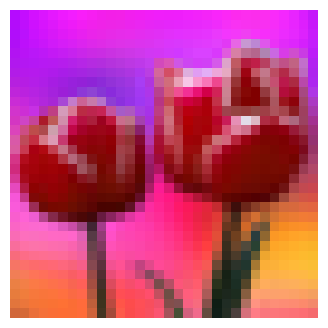

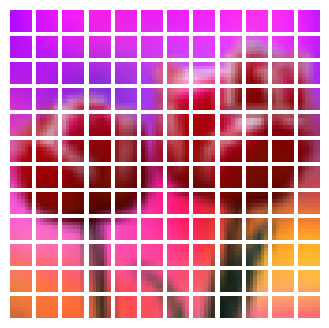

In [7]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))] #seleciona uma imagem aleatória do conjunto de treinamento
plt.imshow(image.astype("uint8"))
plt.axis("off")
# redimensionar a imagem para o tamanho exigido pelo modelo ViT
resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
# Divide a imagem redimensionada em patches
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
#raiz quadrada do número de amostras na imagem é feita porque as amostras devem ser exibidas em uma grade n x n.
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

A camada PatchEncoder transformará linearmente um patch, projetando-o em um vetor de tamanho projection_dim. Além disso, ela adiciona uma incorporação de posição aprendível ao vetor projetado

In [8]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches # número total de amostras em que a imagem é dividida
        self.projection = layers.Dense(units=projection_dim) # camada densa usada para projetar os patches
        # camada de incorporação para aprender uma incorporação de posição para cada patch.
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        # geram as posições dos patches
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        # Os patches são projetados usando a camada densa
        projected_patches = self.projection(patch)
        # A incorporação de posição é adicionada aos patches projetados
        encoded = projected_patches + self.position_embedding(positions)
        return encoded
# salvar e carregar o modelo
    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config


## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

O modelo ViT consiste em vários blocos Transformer, que usam a camada layers. MultiHeadAttention como um mecanismo de autoatenção aplicado à sequência de patches. Os blocos Transformer produzem um tensor [batch_size, num_patches, projection_dim], que é processado por meio de um cabeçote classificador com softmax para produzir a saída final das probabilidades de classe.

Diferentemente da técnica descrita no artigo, que anexa uma incorporação aprendível à sequência de patches codificados para servir como representação da imagem, todas as saídas do bloco Transformer final são remodeladas com layers.Flatten() e usadas como entrada de representação da imagem para o cabeçote do classificador. Observe que a camada layers.GlobalAveragePooling1D também pode ser usada para agregar as saídas do bloco Transformer, especialmente quando o número de patches e as dimensões da projeção são grandes.

In [9]:

def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Cria várias camadas do bloco Transformer
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    # Normaliza a saída do último bloco Transformer.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # Achatar a representação.
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    # Crie a camada de saída do modelo com neurônios num_classes
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.0325 - loss: 4.8802 - top-5-accuracy: 0.1188 - val_accuracy: 0.1048 - val_loss: 3.9244 - val_top-5-accuracy: 0.3070
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.0866 - loss: 4.0137 - top-5-accuracy: 0.2668 - val_accuracy: 0.1626 - val_loss: 3.6448 - val_top-5-accuracy: 0.4008
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.1250 - loss: 3.7406 - top-5-accuracy: 0.3480 - val_accuracy: 0.1938 - val_loss: 3.3699 - val_top-5-accuracy: 0.4674
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.1552 - loss: 3.5302 - top-5-accuracy: 0.4130 - val_accuracy: 0.2222 - val_loss: 3.2261 - val_top-5-accuracy: 0.5052
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.1804 - loss: 3.4006 - top-5-accuracy: 0.4510 - val_accuracy: 0.2472 - val_loss: 3.0683 - val_top-5-accuracy: 0.5426
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.2011 - loss: 3.279

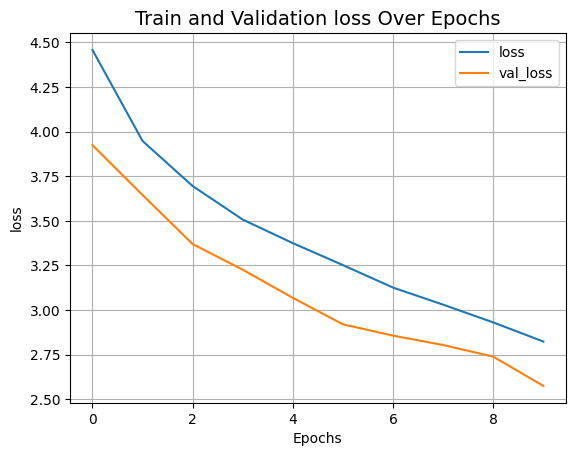

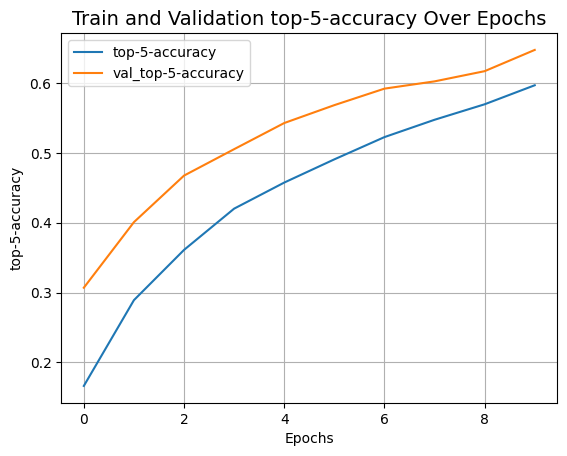

In [10]:

def run_experiment(model):
    # Otimizador AdamW com taxa de aprendizado e taxa de decaimento de peso especificadas
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    # Compilar o modelo
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
# caminho para o arquivo em que os pesos do modelo serão salvos
# salva os pesos do modelo no arquivo especificado sempre que a precisão da validação aumenta.
    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
# Treinar o modelo com os dados de treinamento
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )
# Avalia o modelo em dados de teste e obtém a precisão
    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")


After 100 epochs, the ViT model achieves around 55% accuracy and
82% top-5 accuracy on the test data. These are not competitive results on the CIFAR-100 dataset,
as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.

Note that the state of the art results reported in the
[paper](https://arxiv.org/abs/2010.11929) are achieved by pre-training the ViT model using
the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality
without pre-training, you can try to train the model for more epochs, use a larger number of
Transformer layers, resize the input images, change the patch size, or increase the projection dimensions.
Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices,
but also by parameters such as the learning rate schedule, optimizer, weight decay, etc.
In practice, it's recommended to fine-tune a ViT model
that was pre-trained using a large, high-resolution dataset.